In [4]:
import warnings
from argparse import ArgumentParser

import pandas as pd

from datasets import Priv_NAMES as DATASET_NAMES
from datasets import get_private_dataset
from models import get_all_models
from models import get_model
from utils.Server import train
from utils.Toolbox_analysis import create_latent_df, process_latent_df

warnings.simplefilter(action='ignore', category=FutureWarning)


def parse_args():
    parser = ArgumentParser(description='You Only Need Me', allow_abbrev=False)
    parser.add_argument('--device_id', type=int, default=0, help='The Device Id for Experiment')
    parser.add_argument('--run_simulation', type=bool, default=False, help='The Device Id for Experiment')

    # Communication - epochs
    parser.add_argument('--communication_epoch', type=int, default=8,
                        help='The Communication Epoch in Federated Learning')
    parser.add_argument('--local_epoch', type=int, default=3, help='The Local Epoch for each Participant')

    # Participants info
    #TODO: LINK NUMBER OF PARTICIPANTS WITH SIMULATION
    parser.add_argument('--parti_num', type=int, default=None, help='The Number for Participants. If "None" will be setted as the sum of values described in --domain')
    parser.add_argument('--online_ratio', type=float, default=1, help='The Ratio for Online Clients')

    # Data parameters
    parser.add_argument('--dataset', type=str, default='fl_leaks', choices=DATASET_NAMES, help='Which scenario to perform experiments on.')
    parser.add_argument('--experiment_id', type=str, default='PIPELINE_PATTERNS', help='Which scenario the experiment is for.')
    parser.add_argument('--domains', type=dict, default={
                                                        'Graeme': 5,
                                                        # 'Balerma': 3,
                                                        },
                        help='Domains and respective number of participants.')

    ## Time series preprocessing
    parser.add_argument('--interval_agg', type=int, default=2 * 60 ** 2,
                        help='Agregation interval (seconds) of time series')
    parser.add_argument('--window_size', type=int, default=84, help='Rolling window length')

    # Model (AER) parameters
    parser.add_argument('--input_size', type=int, default=5, help='Number of sensors')  #TODO adaptar
    parser.add_argument('--output_size', type=int, default=5, help='Shape output - dense layer')
    parser.add_argument('--lstm_units', type=int, default=30,
                        help='Number of LSTM units (the latent space will have dimension 2 times bigger')
    parser.add_argument('--detect_anomalies', type=bool, default=True)

    # Federated parameters
    parser.add_argument('--model', type=str, default='fpl', help='Federated Model name.', choices=get_all_models()) #fedavg
    
    parser.add_argument('--structure', type=str, default='homogeneity')

    parser.add_argument('--pri_aug', type=str, default='weak',  # weak strong
                        help='Augmentation for Private Data')
    parser.add_argument('--learning_decay', type=bool, default=False, help='The Option for Learning Rate Decay')
    parser.add_argument('--averaging', type=str, default='weight', help='The Option for averaging strategy')

    parser.add_argument('--infoNCET', type=float, default=0.02, help='The InfoNCE temperature')
    parser.add_argument('--T', type=float, default=0.05, help='The Knowledge distillation temperature')
    parser.add_argument('--weight', type=int, default=1, help='The Weigth for the distillation loss')

    # torch.set_num_threads(4)
    # def add_management_args(parser: ArgumentParser) -> None:
    #     parser.add_argument('--csv_log', action='store_true',
    #                         help='Enable csv logging',default=False)
    #
    # add_management_args(parser)
    #
    args, unknown = parser.parse_known_args()

    if args.parti_num is None:
        args.parti_num = sum(args.domains.values())
    #
    # best = best_args[args.dataset][args.model]
    #
    # for key, value in best.items():
    #     setattr(args, key, value)
    #
    # if args.seed is not None:
    #     set_random_seed(args.seed)

    return args

In [5]:
args = parse_args()

results = {}

for scenario in ['Baseline']:

    results[scenario] = {}

    priv_dataset = get_private_dataset(args)

    backbones_list = priv_dataset.get_backbone(parti_num=args.parti_num,
                                               names_list=None,
                                               n_series=args.input_size)

    model = get_model(backbones_list, args, priv_dataset)

    # priv_dataset.EXP_ID = ['Drift_PIPELINE_ALERNATIVE']
    # priv_dataset.DOMAINS_LIST = ['Balerma']

    priv_train_loaders, aux_latent = train(model=model,
                                           private_dataset=priv_dataset,
                                           scenario=scenario,
                                           args=args)

    results[scenario]['dl'] = priv_train_loaders
    results[scenario]['lat'] = aux_latent
    results[scenario]['model'] = model

Local Pariticipant 0 MSE = 0.030,InfoNCE = 0.000: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9543	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9620	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8876	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9600	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9424	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 1 MSE = 0.059,InfoNCE = 2.746: 100%|██████████| 3/3 [00:09<00:00,  3.16s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9487	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9620	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8879	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9600	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9504	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 4 MSE = 0.043,InfoNCE = 3.123: 100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9416	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9715	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8254	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9499	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9744	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 3 MSE = 0.024,InfoNCE = 2.754: 100%|██████████| 3/3 [00:10<00:00,  3.46s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9385	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9222	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8590	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9129	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9766	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 1 MSE = 0.026,InfoNCE = 3.070: 100%|██████████| 3/3 [00:14<00:00,  4.81s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9228	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9329	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8615	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9487	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 1 MSE = 0.026,InfoNCE = 2.972: 100%|██████████| 3/3 [00:13<00:00,  4.55s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9213	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9455	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8763	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9315	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 2 MSE = 0.019,InfoNCE = 2.997: 100%|██████████| 3/3 [00:17<00:00,  5.67s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9360	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9715	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8814	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9529	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 1 MSE = 0.020,InfoNCE = 2.963: 100%|██████████| 3/3 [00:14<00:00,  4.90s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9355	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9715	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9076	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9878	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


In [6]:
import matplotlib.pyplot as plt
import torch

def extract_value(data_point, index):
    """Helper to extract float from tensor or float at a given index in a tuple."""
    value = data_point[index]
    if isinstance(value, torch.Tensor):
        return value.item()
    return float(value)

def plot_all_clients_side_by_side_proto(model, priv_train_loaders, metric='mse'):
    """
    Plot all clients' training history:
      - Left: all loss types (total_loss, mse, infonet)
      - Right: selected metric from metrics data
    """
    loss_labels = ['Total Loss', 'MSE', 'InfoNet']
    n_loss_types = len(loss_labels)
    loss_indices = range(n_loss_types)

    n_clients = len(model.nets_list)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Left Plot: All Losses ---
    for client_id in range(n_clients):
        fit_history = model.nets_list[client_id].fit_history

        if not fit_history:
            continue

        for idx in loss_indices:
            y_vals = [extract_value(record, idx) for record in fit_history]
            axes[0].plot(
                y_vals,
                label=f'Client {client_id} - {loss_labels[idx]}'
            )

    axes[0].set_title('Client Loss Components Over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()

    # --- Right Plot: Selected Metric ---
    metric_map = {
        'acc': 0,
        'prec': 1,
        'rec': 2,
        'f1': 3,
        'mse': 1,       # reuse index for common case
        'infonet': 2    # reuse index for convenience if needed
    }

    if metric not in metric_map:
        raise ValueError(f"Invalid metric '{metric}'. Choose from: {list(metric_map.keys())}")

    metric_idx = metric_map[metric]

    for client_id in range(n_clients):
        metrics = priv_train_loaders[client_id]['metrics']
        y_vals = [extract_value(record, metric_idx) for record in metrics]
        axes[1].plot(y_vals, label=f'Client {client_id}')

    axes[1].set_title(f'{metric.upper()} per Client')
    axes[1].set_xlabel('Round')
    axes[1].set_ylabel(metric.upper())
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


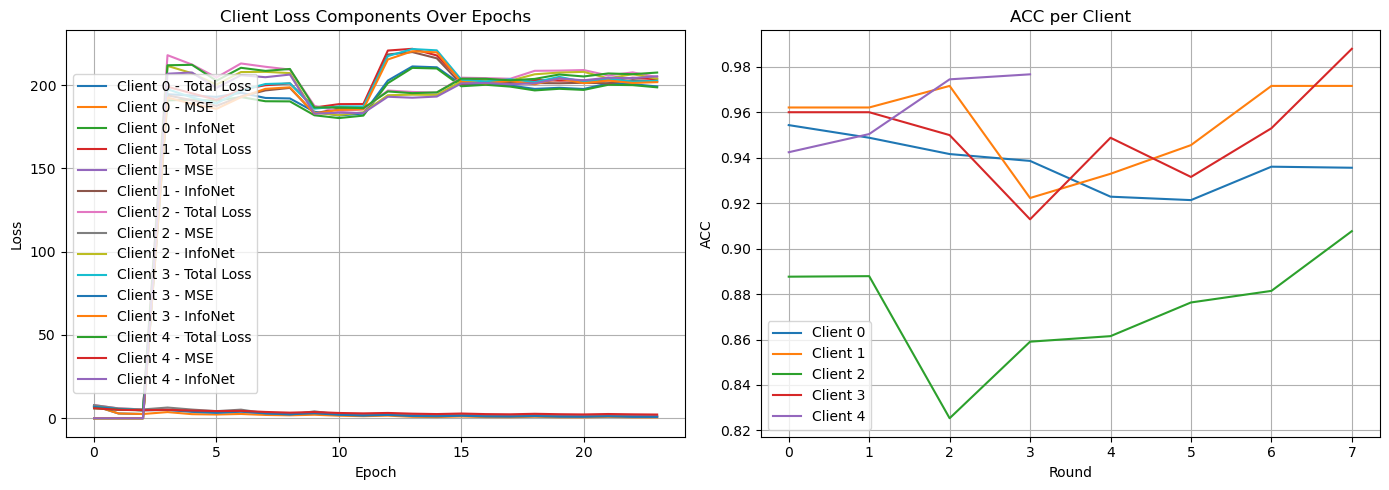

In [7]:
from utils.Toolbox_analysis import plot_all_clients_side_by_side

plot_all_clients_side_by_side_proto(model, priv_train_loaders, metric='acc')

In [9]:
# label_clients = ['District_A', 'District_B', 'District_C', 'District_D', 'District_E']
# label_clients = ['District_A', 'District_B', 'District_C']
label_clients = ['District_A', 'District_B', 'District_C', 'District_D', 'District_E',
                 'District_2A', 'District_2B', 'District_2C']

base_index = results['Baseline']['dl'][0]['X_index']

latent_dfs = {}
for scenario, case in results.items():
    latent_dfs[scenario] = {}
    for epoch, space in enumerate(case['lat']):
        aux_latents = []
        for i, client in enumerate(space):
            baseline_lat = create_latent_df(X_index=base_index,
                                            x_lat=client,
                                            label=scenario + '__' + label_clients[i] + '__' + str(epoch),
                                            is_unix=True)

            aux_latents.append(baseline_lat)

        df_latent = pd.concat(aux_latents)

        df_latent, df_pca_raw, df_umap_raw, df_pca_scaled, df_umap_scaled = process_latent_df(df_latent, umap_neighbors=50, umap_min_dist=0.95)

        latent_dfs[scenario][epoch] = {}
        latent_dfs[scenario][epoch]['latent_space'] = df_latent
        latent_dfs[scenario][epoch]['pca_raw'] = df_pca_raw
        latent_dfs[scenario][epoch]['pca_scl'] = df_pca_scaled
        latent_dfs[scenario][epoch]['umap_raw'] = df_umap_raw
        latent_dfs[scenario][epoch]['umap_scl'] = df_umap_scaled

In [12]:
import pickle

agg_int = int((args.interval_agg) / (60**2))
with open(f'results/exp_latente_results_graeme_{args.experiment_id}_{args.communication_epoch}_{args.local_epoch}_{agg_int}_{args.window_size}_proto_month.pkl', 'wb') as file:
    pickle.dump(results, file)

with open(f'results/exp_latente_df_graeme_{args.experiment_id}_{args.communication_epoch}_{args.local_epoch}_{agg_int}_{args.window_size}_proto_month.pkl', 'wb') as file:
    pickle.dump(latent_dfs, file)

In [ ]:
PARO

In [9]:
import pickle

with open(f'results/exp_latente_results_graeme_PIPELINE_PATTERNS_8_3_2_84_proto_month.pkl', 'rb') as file:
    results = pickle.load(file)

In [13]:
results['Baseline'].keys()

dict_keys(['dl', 'lat', 'model'])

In [17]:
results['Baseline']['dl'][0].keys()

dict_keys(['X_raw', 'X', 'X_norm', 'index', 'y', 'X_index', 'y_index', 'ry_hat', 'y_hat', 'fy_hat', 'x_lat', 'errors', 'results', 'anomalies', 'metrics'])

In [29]:
len(results['Baseline']['lat'][0])

5

In [42]:
results['Baseline']['dl'][0]['metrics']

[(0.9542876981830807, 0.0, 0.0, 0.0),
 (0.9487327855572272, 0.0, 0.0, 0.0),
 (0.9415576900821664, 0.0, 0.0, 0.0),
 (0.9385487790764958, 0.0, 0.0, 0.0),
 (0.9228098599699109, 0.0, 0.0, 0.0),
 (0.9213054044670755, 0.0, 0.0, 0.0),
 (0.9360027774563129, 0.0, 0.0, 0.0),
 (0.9355398680708251, 0.0, 0.0, 0.0)]

In [55]:
results['Baseline']['model'].trainloaders[0].shape

(4237, 84, 5)

In [57]:
results['Baseline']['model'].nets_list[0].fit_history

[(tensor(7.5164, requires_grad=True),
  7.516445241868496,
  tensor(0., requires_grad=True)),
 (tensor(2.8596, requires_grad=True),
  2.859574157744646,
  tensor(0., requires_grad=True)),
 (tensor(2.5497, requires_grad=True),
  2.549696523696184,
  tensor(0., requires_grad=True)),
 (tensor(194.5506, requires_grad=True), 3.702725660055876, 190.84782309894666),
 (tensor(193.7785, requires_grad=True),
  2.4540869295597076,
  191.32438879889938),
 (tensor(192.9573, requires_grad=True), 2.2449913695454597, 190.7123800399355),
 (tensor(195.4137, requires_grad=True),
  2.5715605709701777,
  192.84213847000726),
 (tensor(192.3237, requires_grad=True),
  1.9828082583844662,
  190.34082966562934),
 (tensor(192.0226, requires_grad=True),
  1.7671292163431644,
  190.25547320624958),
 (tensor(184.0327, requires_grad=True), 2.106182413175702, 181.92653792996245),
 (tensor(181.7768, requires_grad=True),
  1.5387288574129343,
  180.23806432820857),
 (tensor(182.9681, requires_grad=True),
  1.251845912